In [1]:
import sys
import os
sys.path.append(os.getcwd() + '/lib/modular_rl')
from gym.envs import make
from modular_rl import *
import argparse
import _pickle as cPickle
from tabulate import tabulate
import shutil, os, logging
import gym
import numpy as np
from gym import spaces, logger
from gym.utils import seeding
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize

Using Theano backend.


In [2]:
steps = 10
gym.register(
    id='TestEnv-v0',
    entry_point='__main__:TestEnv',
    max_episode_steps=steps,
)

In [3]:
def _unitary_to_observation(unitary):
    return np.hstack((np.real(unitary).flatten(), np.imag(unitary).flatten()))

def _observation_to_unitary(observation):
    dim = int(np.sqrt(len(observation)/2))
    return np.reshape(observation[:dim**2], (dim, dim))+1j*np.reshape(observation[dim**2:], (dim, dim))

def _calculate_infidelity(actual, target):
    dimension = len(actual)
    return 1.-((1/dimension)*np.abs(np.trace(np.matmul(np.conjugate(np.transpose(target)), actual))))**2
           
def _pad_to_length(array, length, mode):
    assert len(array) <= length
    return np.pad(array, (0, length-len(array)), mode)


target = np.array([[0,1],[1,0]])
basis = np.array([[[0,1],[1,0]],[[0,-1j],[1j,0]],[[1,0],[0,-1]]])

class TestEnv(gym.Env):

    def __init__(self):
        self._fig = None
        self._target = target
        self._basis = basis

        d = len(target)
        self.action_space = spaces.Box(low=-1*np.ones(len(basis)), high=np.ones(len(basis)), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1*np.ones(2*d**2), high=np.ones(2*d**2), dtype=np.float32)
        
        self.reset()
        self.seed()
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        hamiltonian = np.sum(np.array([b * weight for (b, weight) in zip(self._basis, action)]), axis=0)
        self._unitary = np.matmul(expm(-1j*hamiltonian), self._unitary)
        
        infidelity = _calculate_infidelity(self._unitary, self._target)
        self._done = infidelity < 0.001
        reward = -0.1 - infidelity
        self._infidelity_history.append(infidelity)
        for i,a in enumerate(action):
            self._pulse_history[i].append(a)
        return _unitary_to_observation(self._unitary), reward, self._done, {}

    def reset(self):
        self._pulse_history = [[] for _ in range(len(basis))]
        self._unitary = np.array([[1, 0], [0, 1]], dtype=np.complex)
        self._infidelity_history = [_calculate_infidelity(self._unitary, self._target)]
        self._done = False
        return _unitary_to_observation(self._unitary)

    def render(self, mode='human'):
        done = self._done or len(self._infidelity_history) == steps+1
        if not done:
            return
        
        if not self._fig:
            self._fig, self._axes = plt.subplots(1 + len(self._basis), figsize=(6, 2*(1+len(self._basis))))
            self._fig.subplots_adjust(hspace=0.5)
            self._axes[0].set_title("Infidelity")
            self._infidelity_line, = self._axes[0].plot(np.ones(steps+1))
            self._axes[0].set_ylim(-0.1, 1.1)
            
            self._pulse_lines = []
            for i, ax in enumerate(self._axes[1:]):
                ax.set_title("Pulse {0}".format(i))
                pulse_line, = ax.plot(np.zeros(steps+1))
                ax.set_ylim(-1.1, 1.1)
                self._pulse_lines.append(pulse_line)
            
            #plt.show(block=False)
        self._infidelity_line.set_xdata(np.arange(len(self._infidelity_history)))
        self._infidelity_line.set_ydata(self._infidelity_history)
        assert len(self._pulse_lines) == len(self._pulse_history)
        for line, pulse, ax in zip(self._pulse_lines, self._pulse_history, self._axes[1:]):
            n = len(pulse)
            line.set_xdata(np.repeat(np.arange(n+1), 2)[1:-1])
            line.set_ydata(np.array(pulse)[np.repeat(np.arange(n), 2)])
            ymin, ymax = ax.get_ylim()
            ax.set_ylim(min(ymin, min(pulse)-0.1), max(ymax, max(pulse)+0.1))

        self._fig.canvas.draw()

    def close(self):
        pass

In [4]:
def _animate_rollout(env, agent, n_timesteps,delay=.01,stochastic=False):
    ob = env.reset()
    env.render()
    for i in range(n_timesteps):
        agent.set_stochastic(stochastic)
        a, _info = agent.act(ob)
        agent.set_stochastic(True)
        (ob, _rew, done, _info) = env.step(a)
        env.render()
        if done:
            print("Terminated after {0} timesteps {1}".format(i+1, stochastic))
            return

COUNTER = 0
def do(argstring):
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    update_argument_parser(parser, GENERAL_OPTIONS)
    parser.add_argument("--env",required=True)
    parser.add_argument("--agent",required=True)
    parser.add_argument("--plot",action="store_true")
    parser.add_argument("--stochastic",action="store_true")
    arg_bits = [arg for arg in argstring.split(" ") if arg not in ('-h', '--help')]
    args,_ = parser.parse_known_args(arg_bits)
    env = make(args.env)
    #env.render()
    env_spec = env.spec
    mondir = args.outfile + ".dir"
    if os.path.exists(mondir): shutil.rmtree(mondir)
    os.mkdir(mondir)
    env = gym.wrappers.Monitor(env, mondir, video_callable=None if args.video else VIDEO_NEVER)
    agent_ctor = get_agent_cls(args.agent)
    update_argument_parser(parser, agent_ctor.options)
    args = parser.parse_args(argstring.split(" "))
    if args.timestep_limit == 0:
        args.timestep_limit = env_spec.max_episode_steps
    cfg = args.__dict__
    np.random.seed(args.seed)
    agent = agent_ctor(env.observation_space, env.action_space, cfg)
    if args.use_hdf:
        hdf, diagnostics = prepare_h5_file(args)
    gym.logger.setLevel(logging.WARN)


    def callback(stats):
        global COUNTER
        COUNTER += 1
        # Print stats
        print("*********** Iteration %i ****************" % COUNTER)
        print(tabulate(filter(lambda item : np.asarray(item[1]).size==1, stats.items()))) #pylint: disable=W0110
        # Store to hdf5
        if args.use_hdf:
            for (stat,val) in stats.items():
                if np.asarray(val).ndim==0:
                    diagnostics[stat].append(val)
                else:
                    assert val.ndim == 1
                    diagnostics[stat].extend(val)
            if args.snapshot_every and ((COUNTER % args.snapshot_every==0) or (COUNTER==args.n_iter)):
                hdf['/agent_snapshots/%0.4i'%COUNTER] = np.array(cPickle.dumps(agent,-1))
        # Plot
        if args.plot:
            _animate_rollout(env, agent, min(500, args.timestep_limit), delay=0.001, stochastic=args.stochastic)

    run_policy_gradient_algorithm(env, agent, callback=callback, usercfg = cfg)

    if args.use_hdf:
        hdf['env_id'] = env_spec.id
        try: hdf['env'] = np.array(cPickle.dumps(env, -1))
        except Exception: print("failed to pickle env") #pylint: disable=W0703
    
    return cfg,agent,env

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


policy gradient config {'timestep_limit': 10, 'n_iter': 10, 'parallel': 0, 'timesteps_per_batch': 100, 'gamma': 0.99, 'lam': 1.0, 'seed': 0, 'metadata': '', 'outfile': '/tmp/a.h5', 'use_hdf': 0, 'snapshot_every': 0, 'load_snapshot': '', 'video': 0, 'env': 'TestEnv-v0', 'agent': 'modular_rl.agentzoo.TrpoAgent', 'plot': True, 'stochastic': False, 'hid_sizes': [64, 64], 'activation': 'tanh', 'cg_damping': 0.001, 'max_kl': 0.01, 'filter': 1}
{'task': b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT', 'funcalls': 30, 'nit': 25, 'warnflag': 1}
lagrange multiplier: 4.960292714185901 gnorm: 0.5087583
fval before -1.3004649769176136e-08
a/e/r 0.10758943124250932 0.09920587230825252 1.0845066802921444
fval after -0.10758944424715909
success True
*********** Iteration 1 ****************
------------------  ------------
NumEpBatch          11
EpRewMean           -8.74686
EpRewSEM             0.27413
EpRewMax            -6.70022
EpLenMean           10
EpLenMax            10
RewPerStep          -0.8746

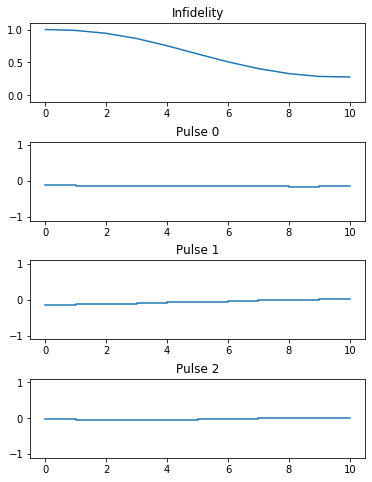

In [5]:
%matplotlib inline
cfg,agent,env = do("--env TestEnv-v0 --agent modular_rl.agentzoo.TrpoAgent --video 0 --n_iter 10 --timesteps_per_batch 100 --plot")

In [6]:
def callback(stats):
    global COUNTER
    COUNTER += 1
    # Print stats
    print("*********** Iteration %i ****************" % COUNTER)
    print(tabulate(filter(lambda item : np.asarray(item[1]).size==1, stats.items()))) #pylint: disable=W0110

    _animate_rollout(env, agent, steps, stochastic=True)

policy gradient config {'timestep_limit': 10, 'n_iter': 10, 'parallel': 0, 'timesteps_per_batch': 100, 'gamma': 0.99, 'lam': 1.0, 'seed': 0, 'metadata': '', 'outfile': '/tmp/a.h5', 'use_hdf': 0, 'snapshot_every': 0, 'load_snapshot': '', 'video': 0, 'env': 'TestEnv-v0', 'agent': 'modular_rl.agentzoo.TrpoAgent', 'plot': True, 'stochastic': False, 'hid_sizes': [64, 64], 'activation': 'tanh', 'cg_damping': 0.001, 'max_kl': 0.01, 'filter': 1}
{'task': b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT', 'funcalls': 29, 'nit': 25, 'warnflag': 1}
lagrange multiplier: 5.131071924890188 gnorm: 0.6928683
fval before -3.251162442294034e-09
a/e/r 0.09983521916649558 0.10262133395009701 0.9728505304271696
fval after -0.09983522241765802
success True
*********** Iteration 11 ****************
------------------  ------------
NumEpBatch          11
EpRewMean           -8.72636
EpRewSEM             0.155634
EpRewMax            -7.90973
EpLenMean           10
EpLenMax            10
RewPerStep          -0.872

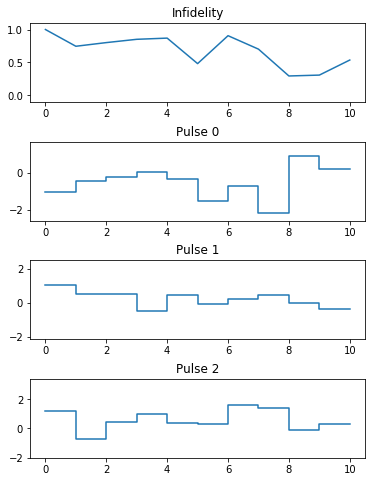

In [7]:
env = gym.make("TestEnv-v0")
%time run_policy_gradient_algorithm(env, agent, callback=callback, usercfg = cfg)

In [15]:
CPU times: user 5.35 s, sys: 2.07 s, total: 7.42 s
Wall time: 3.94 s

SyntaxError: invalid syntax (<ipython-input-15-0dfdc3f79dce>, line 1)